# **Evaluación y despliegue del modelo de mejor desempeño.**

---

A partir del entrenamiento y la identificación de Hiperparatmetros de apartados anteriores se realiza la evaluación del modelo con mejor desempeño, la creación del modelo en MLflow y le despliegue del modelo.



## **Librerias y Cargue de Datos**

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import joblib
from sklearn.ensemble import RandomForestClassifier
import mlflow
import os
from IPython.display import display
from pyngrok import ngrok
import mlflow.sklearn
import re
import requests

In [2]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))

  return df

In [6]:
DATA_URL = 'https://github.com/cris21309/tdsp_template_grupo8/blob/preprocesamiento/scripts/preprocessing/train_test_array.npz?raw=true'

path = tf.keras.utils.get_file('train_test_array.npz', DATA_URL)

with np.load(path) as data:
  X_train = data['X_train']
  X_test  = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']

## **Evaluacion Random Forest con mejores Hiperparameros**
----
Teniendo en cuenta los resultados del entrenamiento se realiza el entrenamiento las métricas con el modelo de mejor desempeño, con los hiperparametros identificados y para la totalidad del conjunto de entrenamiento.

In [7]:
RF_model= RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=50).fit(X_train,y_train)

In [8]:
joblib.dump(RF_model, "RF_model.joblib")

['RF_model.joblib']

In [9]:
y_pred = RF_model.predict(X_test)

In [10]:
print(classification_report(y_test,y_pred, target_names=['No_Diabetes', 'Diabetes'], digits=4))

              precision    recall  f1-score   support

 No_Diabetes     0.9701    0.9997    0.9846     17534
    Diabetes     0.9948    0.6810    0.8085      1696

    accuracy                         0.9716     19230
   macro avg     0.9824    0.8403    0.8966     19230
weighted avg     0.9722    0.9716    0.9691     19230



In [11]:
#Estimación de los estadísticos de desempeño del modelo.
names=['No_Diabetes', 'Diabetes']
print(f'Orden de las etiquetas: {names}')
print(f'Precisión por clase: \t{precision_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, y_pred, average=None)}')
print(f'F1 por clase: \t{f1_score(y_test, y_pred, average=None)}')

Orden de las etiquetas: ['No_Diabetes', 'Diabetes']
Precisión por clase: 	[0.97005922 0.99483204]
Recall por clase: 	[0.99965781 0.68101415]
F1 por clase: 	[0.98463613 0.80854043]


In [12]:
# Generación de la matriz de confusión.
RF_mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(RF_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17528        6
           Diabetes               541     1155

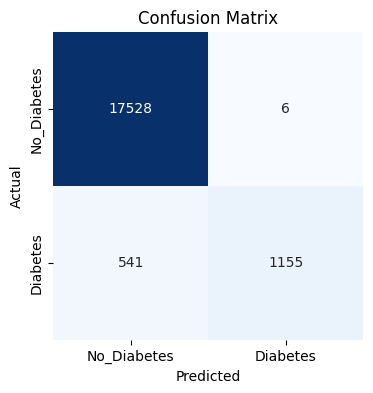

In [13]:
plt.figure(figsize=(4, 4))
sns.heatmap(RF_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

-----

Teniendo en cuenta los resultados de los apartados anteriores donde se realizó el entrenamiento de los diferentes modelos y se identificaron los mejores hiper parámetros, se realiza la evaluación completa del modelo. Se evidencia que para un clasificador basado en Random Forest se obtienen una exactitud de hasta 0.97 y con un buen desempeño en la estimación para las diferentes clases, siendo esto lo esperado en el desarrollo del proyecto.

---------

## Creación del modelo en ML Flow

In [15]:
command = """
mlflow server \
        --backend-store-uri sqlite:///tracking.db \
        --default-artifact-root file:mlruns \
        -p 5000 &
"""
get_ipython().system_raw(command)

/home/kevo/.local/lib/python3.10/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[2024-05-30 17:27:17 -0500] [31855] [INFO] Starting gunicorn 22.0.0
[2024-05-30 17:27:17 -0500] [31855] [INFO] Listening at: http://127.0.0.1:5000 (31855)
[2024-05-30 17:27:17 -0500] [31855] [INFO] Using worker: sync
[2024-05-30 17:27:17 -0500] [31856] [INFO] Booting worker with pid: 31856
[2024-05-30 17:27:17 -0500] [31857] [INFO] Booting worker with pid: 31857
[2024-05-30 17:27:17 -0500] [31858] [INFO] Booting worker with pid: 31858
[2024-05-30 17:27:18 -0500] [31859] [INFO] Booting worker with pid: 31859


In [16]:
token = "2gFliDMxc3tfsLh0I0TlwThCN9D_5jpazRWnVfVzhLPrGymzZ" # Agregue el token dentro de las comillas
os.environ["NGROK_TOKEN"] = token

In [17]:
ngrok.connect(5000, "http")

<NgrokTunnel: "https://291a-201-182-249-169.ngrok-free.app" -> "http://localhost:5000">

In [22]:
mlflow.set_tracking_uri("http://localhost:5000")

In [24]:
exp_id = mlflow.create_experiment(name="diabetes_model", artifact_location="mlruns/")

In [26]:
with mlflow.start_run(
        run_name="Randon_Forest",
        experiment_id=exp_id
        ):
    model = RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=50)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.sklearn.log_model(model, "model")

## Despliegue del modelo en MLflow

In [27]:
os.environ["MLFLOW_TRACKING_URI"] = "http://localhost:5000"

In [28]:
command = """
mlflow models serve -m 'models:/diabetes_model/1' -p 8001 --env-manager 'local' &
"""
get_ipython().system_raw(command)

/home/kevo/.local/lib/python3.10/site-packages/pydantic/_internal/_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
2024/05/30 17:34:44 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2024/05/30 17:34:44 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:8001 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2024-05-30 17:34:44 -0500] [32317] [INFO] Starting gunicorn 22.0.0
[2024-05-30 17:34:44 -0500] [32317] [INFO] Listening at: http://127.0.0.1:8001 (32317)
[2024-05-30 17:34:44 -0500] [32317] [INFO] Using worker: sync
[2024-05-30 17:34:44 -0500] [32318] [INFO] Booting worker with pid: 32318


In [84]:
data_request = X_test[120:140].tolist()
for i in range(len(data_request)):
    print(f"Características de entrada {i} : {data_request[i]}" )

Características de entrada 0 : [0.2492492492492492, 0.28279645191409897, 0.18181818181818188, 0.5454545454545454, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Características de entrada 1 : [0.8123123123123123, 0.23179271708683477, 0.4545454545454545, 0.6363636363636364, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Características de entrada 2 : [0.024024024024024024, 0.10270774976657329, 0.4181818181818181, 0.36363636363636365, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Características de entrada 3 : [0.4244244244244244, 0.20203081232493, 0.4727272727272728, 0.045454545454545414, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Características de entrada 4 : [0.537037037037037, 0.24451447245564892, 0.4909090909090911, 0.3545454545454545, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Características de entrada 5 : [0.587087087087087, 0.22934173669467786, 0.0, 0.2090909090909091, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Caract

In [85]:
r = requests.post("http://localhost:8001/invocations", json={"inputs": data_request})
predictions = re.findall(r'\d+', r.text)
predictions = list(map(int, predictions))
for i in range(len(predictions)):
    print(f"predición {i}: {predictions[i]}")

predición 0: 0
predición 1: 1
predición 2: 0
predición 3: 0
predición 4: 0
predición 5: 0
predición 6: 1
predición 7: 0
predición 8: 0
predición 9: 0
predición 10: 0
predición 11: 0
predición 12: 0
predición 13: 0
predición 14: 0
predición 15: 0
predición 16: 0
predición 17: 0
predición 18: 0
predición 19: 0
